In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [ ]:
data = pd.read_csv("/content/UNRATE.csv", header=None,  names=['Month', 'Unrate'])
data["Month"] = pd.to_datetime(data["Month"], format='%d-%m-%Y')
data = data.set_index("Month")
data

,Unrate
Month,
1948-01-01,3.4
1948-02-01,3.8
1948-03-01,4.0
1948-04-01,3.9
1948-05-01,3.5
...,...
2019-11-01,3.5
2019-12-01,3.5
2020-01-01,3.6


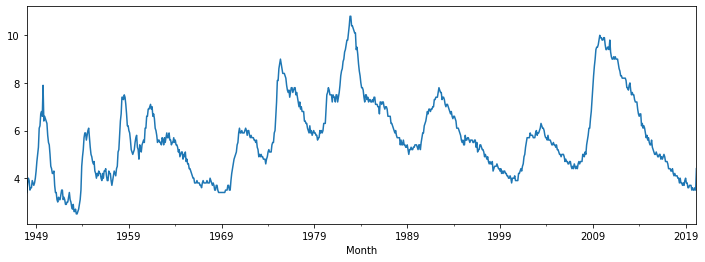

In [ ]:
data.Unrate.plot(figsize=(12,4))

## Stationarity Transformation

### Boxcox

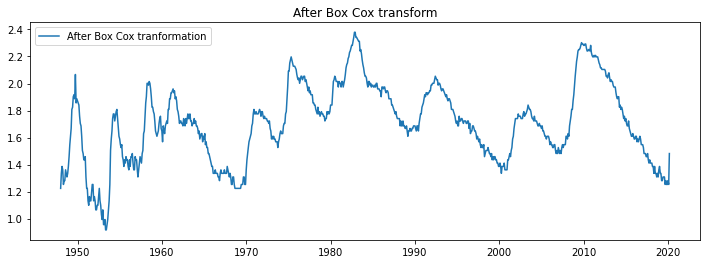

In [ ]:
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(data['Unrate'], lmbda=0), index = data.index)

plt.figure(figsize=(12,4))
plt.plot(data_boxcox, label='After Box Cox tranformation')
plt.legend(loc='best')
plt.title('After Box Cox transform')
plt.show()

### Differencing

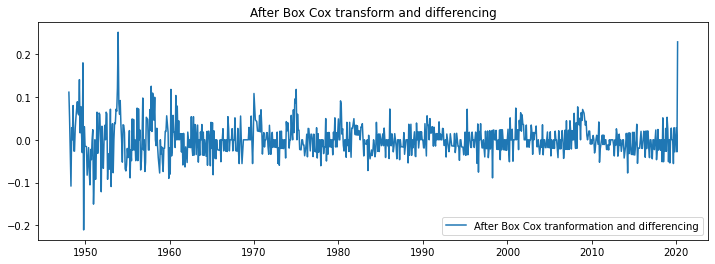

In [ ]:
data_boxcox_diff = pd.Series(data_boxcox - data_boxcox.shift(), data.index)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox tranformation and differencing')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing')
plt.show()

In [ ]:
data_boxcox_diff.dropna(inplace=True)
data_boxcox_diff.tail()

Month
2019-11-01   -0.028171
2019-12-01    0.000000
2020-01-01    0.028171
2020-02-01   -0.028171
2020-03-01    0.228842
dtype: float64

## Train Test Split

In [ ]:
train_len = 612
train = data[:train_len]
test = data[train_len:]
print("test length:", len(test)) 
train_data_boxcox = data_boxcox[:train_len]
test_data_boxcox = data_boxcox[train_len:]
print("test_data_boxcox length:", len(test_data_boxcox)) 
train_data_boxcox_diff = data_boxcox_diff[:train_len-1]
test_data_boxcox_diff = data_boxcox_diff[train_len-1:]
print("test_data_boxcox_diff length:", len(test_data_boxcox_diff))

test length: 255
test_data_boxcox length: 255
test_data_boxcox_diff length: 255


## AR Model

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_data_boxcox_diff, order=(12, 0, 0)) 
model_fit = model.fit()
print(model_fit.params)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


const       0.000466
ar.L1.y     0.060691
ar.L2.y     0.161198
ar.L3.y     0.118645
ar.L4.y     0.090455
ar.L5.y     0.107079
ar.L6.y     0.008286
ar.L7.y    -0.029412
ar.L8.y     0.032450
ar.L9.y     0.006198
ar.L10.y   -0.124660
ar.L11.y    0.047124
ar.L12.y   -0.148533
dtype: float64


#### Recover Original Time Series

In [ ]:
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['ar_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox_diff'].cumsum()
y_hat_ar['ar_forecast_boxcox'] = y_hat_ar['ar_forecast_boxcox'].add(data_boxcox[0])
y_hat_ar['ar_forecast'] = np.exp(y_hat_ar['ar_forecast_boxcox'])

In [ ]:
results = pd.DataFrame(columns=['Method', 'RMSE', 'MAPE'])

def eval_forecast(forcast, method):
    rmse = np.sqrt(mean_squared_error(test.Unrate, forcast[method][test.index.min():])).round(2)
    mape = np.round(np.mean(np.abs(test.Unrate - forcast[method][test.index.min():])/test.Unrate)*100, 2)
    results.loc[len(results.index)] = [method, rmse, mape]
    return results

In [ ]:
eval_forecast(y_hat_ar, "ar_forecast")

,Method,RMSE,MAPE
0,ar_forecast,2.07,21.5
1,ar_forecast,2.07,21.5


## MA

In [ ]:
model = ARIMA(train_data_boxcox_diff, order=(0, 0, 1)) 
model_fit = model.fit()
print(model_fit.params)

const      0.000439
ma.L1.y    0.095651
dtype: float64


C:\Users\santh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [ ]:
y_hat_ma = data_boxcox_diff.copy()
y_hat_ma['ma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox_diff'].cumsum()
y_hat_ma['ma_forecast_boxcox'] = y_hat_ma['ma_forecast_boxcox'].add(data_boxcox[0])
y_hat_ma['ma_forecast'] = np.exp(y_hat_ma['ma_forecast_boxcox'])

In [ ]:
eval_forecast(y_hat_ma, "ma_forecast")

,Method,RMSE,MAPE
0,ar_forecast,2.07,21.5
1,ma_forecast,2.10,21.6


## ARMA

In [ ]:
model = ARIMA(train_data_boxcox_diff, order=(12, 0, 1))
model_fit = model.fit()
print(model_fit.params)

C:\Users\santh\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\santh\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS wi

const       0.000441
ar.L1.y     0.260081
ar.L2.y     0.149453
ar.L3.y     0.081710
ar.L4.y     0.066801
ar.L5.y     0.090069
ar.L6.y    -0.014159
ar.L7.y    -0.031336
ar.L8.y     0.041317
ar.L9.y     0.002479
ar.L10.y   -0.121210
ar.L11.y    0.077997
ar.L12.y   -0.158456
ma.L1.y    -0.204431
dtype: float64


In [ ]:
y_hat_arma = data_boxcox_diff.copy()
y_hat_arma['arma_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox_diff'].cumsum()
y_hat_arma['arma_forecast_boxcox'] = y_hat_arma['arma_forecast_boxcox'].add(data_boxcox[0])
y_hat_arma['arma_forecast'] = np.exp(y_hat_arma['arma_forecast_boxcox'])

In [ ]:
eval_forecast(y_hat_arma, "arma_forecast")

,Method,RMSE,MAPE
0,ar_forecast,2.07,21.50
1,ma_forecast,2.10,21.60
2,arma_forecast,2.10,21.56


## ARIMA

In [ ]:
model = ARIMA(train_data_boxcox, order=(12, 1, 5)) 
model_fit = model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
y_hat_arima = data_boxcox_diff.copy()
y_hat_arima['arima_forecast_boxcox_diff'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox_diff'].cumsum()
y_hat_arima['arima_forecast_boxcox'] = y_hat_arima['arima_forecast_boxcox'].add(data_boxcox[0])
y_hat_arima['arima_forecast'] = np.exp(y_hat_arima['arima_forecast_boxcox'])

In [ ]:
eval_forecast(y_hat_arima, "arima_forecast")

,Method,RMSE,MAPE
0,ar_forecast,2.07,21.50
1,ar_forecast,2.07,21.50
2,arima_forecast,2.13,21.77
